<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/10_ObjectLocalization/COCO_K-Means/CocoDataset_AnchorBox_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COCO format







# YOLO Anchor boxes







# Intuition behind K-means clustering

In [46]:
y!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2021-07-15 06:42:39--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.169.75
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.169.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  15.4MB/s    in 17s     

2021-07-15 06:42:57 (13.8 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]



In [47]:
!unzip 'annotations_trainval2017.zip'

Archive:  annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/instances_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/captions_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [49]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

In [51]:
#Read COCO JSON File
fptr = open('/content/annotations/instances_train2017.json')
data = json.load(fptr)
print(data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [52]:
#Extract Details
images_df = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations_df = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())

In [53]:
images_df.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,000000522418.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418
2,3,000000184613.jpg,http://images.cocodataset.org/train2017/000000...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613
3,3,000000318219.jpg,http://images.cocodataset.org/train2017/000000...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219
4,3,000000554625.jpg,http://images.cocodataset.org/train2017/000000...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625


In [54]:
annotations_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
1,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509
2,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603
3,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918
4,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072


In [55]:
#Extract the Box Dimensions
annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]
x_list = []
y_list = []
w_list = []
h_list = [] 
for row in range(annotation_map_df.shape[0]):
  x = annotation_map_df['bbox'][row][0]
  y = annotation_map_df['bbox'][row][1]
  w = annotation_map_df['bbox'][row][2]
  h = annotation_map_df['bbox'][row][3]
  x_list.append(x)
  y_list.append(y)
  w_list.append(w)
  h_list.append(h)
box_df = pd.DataFrame(list(zip(x_list, y_list, w_list, h_list)), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)

In [56]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,199.84,200.46,77.71,70.88
1,000000522418.jpg,640.0,480.0,234.22,317.11,149.39,38.55
2,000000184613.jpg,500.0,336.0,239.48,347.87,160.00,57.81
3,000000318219.jpg,556.0,640.0,296.65,388.33,1.03,0.00
4,000000554625.jpg,426.0,640.0,251.87,333.42,125.94,22.71


In [57]:
#Normalize the Box Dimensions based on Image Height and Width
annotation_map_df['x'] = annotation_map_df['x'] / annotation_map_df['width']
annotation_map_df['y'] = annotation_map_df['y'] / annotation_map_df['height']
annotation_map_df['box_width'] = annotation_map_df['box_width'] / annotation_map_df['width']
annotation_map_df['box_height'] = annotation_map_df['box_height'] / annotation_map_df['height']

In [58]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,0.312250,0.556833,0.121422,0.196889
1,000000522418.jpg,640.0,480.0,0.365969,0.660646,0.233422,0.080312
2,000000184613.jpg,500.0,336.0,0.478960,1.035327,0.320000,0.172054
3,000000318219.jpg,556.0,640.0,0.533543,0.606766,0.001853,0.000000
4,000000554625.jpg,426.0,640.0,0.591244,0.520969,0.295634,0.035484


In [59]:
annotation_map_df = annotation_map_df.dropna() 

In [60]:
annotation_map_df.isnull().any()

file_name     False
width         False
height        False
x             False
y             False
box_width     False
box_height    False
dtype: bool

In [61]:
hw_array = annotation_map_df[["box_width", "box_height"]].to_numpy()

In [62]:
hw_array.shape

(118287, 2)

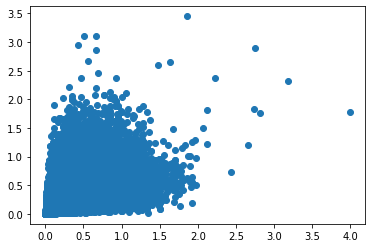

In [63]:
plt.scatter(hw_array[:,0], hw_array[:,1])

In [64]:
np.any(np.isnan(hw_array))

False

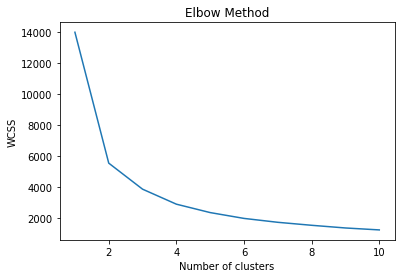

In [65]:
#Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(hw_array)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

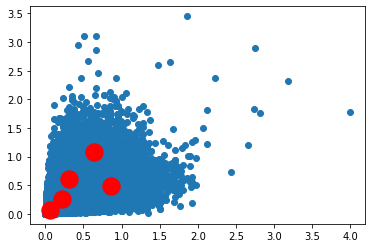

In [66]:
#Determine the optimal number of clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)
plt.scatter(hw_array[:,0], hw_array[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()